<center><h1>A Block Toolkit for Convolutional Neural Networks</h1>
<h2>Matthias Bartolo</h2>

</center>

# Convolutional Neural Network (CNN)

In the captivating realm of neural networks, `CNNs` are a class of deep, feed-forward artificial neural networks, most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics. They have applications in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, and financial time series.

The basic principle behind `CNNs` pertains to the `Area Processing` technique in the field of Computer Vision which as the name suggests; `Convolves` the image with a `Kernel` or `Filter` to produce a `Feature Map` which is a `Convolved Feature` of the original image. The `Kernel` is a small matrix of weights which is convolved with the input layer to produce a `Feature Map`. The `Kernel` is slided over the input layer by a certain `Stride` and the dot product of the weights of the `Kernel` and the input layer is computed at every step which forms a single element of the `Feature Map`. The `Kernel` is slided over the entire input layer to produce the full `Feature Map`. Additionally, the `Kernel` is usually of size `3x3` or `5x5` and the `Stride` is usually `1` or `2`. The `Stride` is the number of pixels by which the `Kernel` slides over the input layer at every step. The `Stride` is usually `1` or `2`. Moreover, it is generally noted that the convolved feature map is `N-2` and `M-2` where `N` and `M` are the dimensions of the input image and the `Kernel` respectively.

Normally a `CNN` or `ConvNet` is made up of multiple layers of `Convolution` operations, `Pooling` operations and `Fully Connected` layers. The `Convolution` and `Pooling` operations are performed on the `Feature Maps` which are the outputs of the previous layer. The `Fully Connected` layers are the last layers of the `CNN` and their outputs are the class scores for the input image. The `Fully Connected` layers are the last layers of the `CNN` and their outputs are the class scores for the input image. The `Fully Connected` layers are the last layers of the `CNN` and their outputs are the class scores for the input image.

Convolutional Neural Networks are usually split into two parts:
- The "base" `Convolutional` part which is made up of `Convolutional` layers and `Pooling` layers, responsible for extracting features from the input image.
- The "head" `Fully Connected` part which is made up of `Fully Connected` layers, responsible for performing classification on the features extracted by the `Convolutional` part.


### Import TensorFlow

`For native GPU support on Windows, you will need to install the following:`
<font size="0.7">

```python
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
python -m pip install "tensorflow<2.11"
# Verify the installation:
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```

</font>

In [1]:
from time import time
import tensorflow as tf
import numpy as np
import seaborn as sns

import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

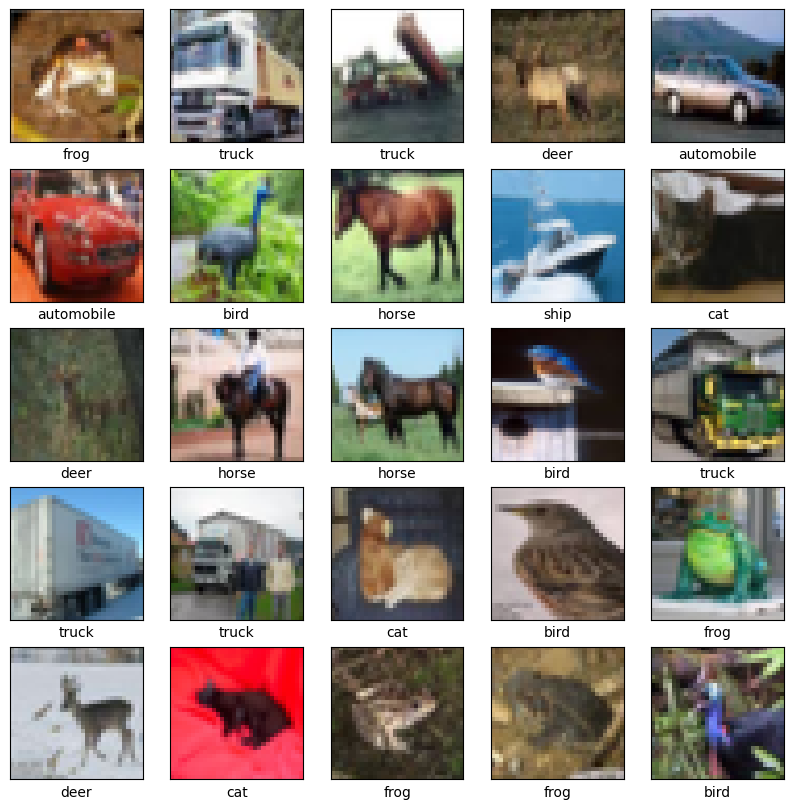

In [2]:
# Loading and splitting the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizing pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Declaring the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting the first 25 images from the training set and displaying the class name below each image
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Creating Fit Function

Following the `Keras` API, we create a `fit` function that will be used to train our model. As the name implies the `fit` function will be used to fit the model to the training data. The `fit` function will take in the following parameters:
- `model`: The model to be trained
- `epochs`: The number of epochs to train the model for
- `optimizer`: The optimizer to be used to train the model
- `verbose`: The verbosity level of the training process
- `batch_size`: The batch size used for training
- `callbacks`: List of callbacks to be used during training
- `colors`: Tuple of colors to be used for plotting
- `do_display`: Whether to display the training process
- `do_save`: Whether to save the trained model
- `save_name`: Name of the saved model

The `fit` function will compile the model with the specified optimizer and loss function. It will then train the model using the training data and evaluate its performance on the validation data. After training, it will plot the training curves and display the test accuracy, test loss, precision, recall, and F1 score. If specified, it will also display the confusion matrix and save the trained model.


In [3]:
def fit(model, epochs:int=100, optimizer=Adam(clipnorm=1.0), verbose:int=1, batch_size:int=256, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)], colors:tuple=('blue','purple','green','cyan'), do_display:bool=False, do_save:bool=False, save_name:str='model'):
    """Function which fits a model to the training data and plots the training process.

    Args:
        model (keras.model): Model to fit
        epochs (int, optional): Number of epochs to train for. Defaults to 10.
        optimizer (str, optional): Optimizer to use. Defaults to 'adam'.
        verbose (int, optional): Verbosity of training. Defaults to 1.
        batch_size (int, optional): Batch size. Defaults to 32.
        callbacks (list, optional): List of callbacks. Defaults to [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)].
        colors (tuple, optional): Colors to use for plotting. Defaults to ('blue','purple','green','cyan').`
        do_save (bool, optional): Whether to save the model. Defaults to False.
        save_name (str, optional): Name of the model to save. Defaults to 'model'.
    """

    # Loading the model
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    # Printing the model summary
    print(model.summary())

    # Setting the start time
    s=time()

    # Creating data augmentation (to prevent overfitting)
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True
    )

    datagen.fit(train_images)

    # Fitting the model
    history = model.fit(
        # datagen.flow(train_images, train_labels, batch_size=batch_size),
        train_images, train_labels,
        verbose=verbose,
        steps_per_epoch=train_images.shape[0] // batch_size,
        epochs=epochs,
        validation_data=(test_images, test_labels),
        callbacks=callbacks,
    )

    # Printing the training time
    print(f'\033[36mTraining Time: {round(time()-s,2)}s\033[0m')
    print('*'*50)

    # Plotting Training process
    plt.figure(figsize=(10,7))
    plt.style.use('seaborn-v0_8')
    plt.plot(history.history['accuracy'], label='Train Accuracy', color = colors[0])
    plt.plot(history.history['loss'], label = 'Train Loss', color = colors[1], linestyle='dashed')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = colors[2])
    plt.plot(history.history['val_loss'], label = 'Validation Loss', color = colors[3], linestyle='dashed')
    plt.title('Training Curves', fontsize=17)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Testing the model
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    # Calculating the Precision, Recall and F1 Score
    y_pred = model.predict(test_images)
    y_pred = [np.argmax(i) for i in y_pred]
    
    # Printing the test results
    print(f'\033[35mTest Accuracy: {round(test_acc,2)}\033[0m')
    print(f'\033[34mTest Loss: {round(test_loss,2)}\033[0m')
    print(f'\033[33mTest Precision: {round(precision_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[32mTest Recall: {round(recall_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[31mTest F1 Score: {round(f1_score(test_labels, y_pred, average="weighted"),2)}\033[0m')

    # Plotting the confusion matrix
    if do_display:
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(10,7))
        plt.title('Confusion Matrix', fontsize=17)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.ylabel('Actual', fontsize=14)
        plt.xlabel('Predicted', fontsize=14)
        plt.show()

    # Saving the model
    if do_save:
        model.save(f'{save_name}.h5')

    return test_acc

### Defining Higher Order Activation Functions

`Activation functions` are mathematical equations that determine the output of a neural network. The function is attached to each neuron in the network, and determines whether it should be activated (“fired”) or not, based on whether each neuron’s input is relevant for the model’s prediction. `Activation functions` also help normalize the output of each neuron to a range between 1 and 0 or between -1 and 1. These functions are crucial to the neural network’s ability to learn complex patterns, by allowing it to introduce non-linearities in its outputs.

In [4]:
def mish(x):
    """Mish Activation Function.

    Formula: 
        x * tanh(softplus(x))
    
    """
    return x * K.tanh(K.softplus(x))

def gelu(x):
    """Gelu Activation Function.

    Formula:
        0.5 * x * (1 + tanh(sqrt(2 / pi) * (x + 0.044715 * x^3)))

    """
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def swish(x):
    """Swish Activation Function.

    Formula:
        x * sigmoid(x)
    """
    return x * tf.sigmoid(x)

def relu6(x):
    """ReLU6 Activation Function.

    Formula:
        min(max(0, x), 6)
    """
    return tf.minimum(tf.maximum(0, x), 6)

def selu(x):
    """SELU Activation Function.

    Formula:
        scale * elu(x, alpha)
    """
    return tf.nn.selu(x)

def elu(x, alpha=1.0):
    """ELU Activation Function.

    Formula:
        x if x > 0 else alpha * (exp(x) - 1)
    """
    return tf.nn.elu(x, alpha)

def leaky_relu(x, alpha=0.01):
    """Leaky ReLU Activation Function.

    Formula:
        x if x > 0 else alpha * x
    """
    return tf.nn.leaky_relu(x, alpha)

def prelu(x, alpha=0.01):
    """PReLU Activation Function.

    Formula:
        x if x > 0 else alpha * x
    """
    return tf.keras.layers.PReLU(alpha)(x)

### Defining Individual Blocks for Model Construction

#### Convolutional Block

In [5]:
def Conv_Block(num_filters, dropout_rate, input_shape=None, activation=["relu"]*3, kernel_size=[(3, 3)]*3, padding='same', strides=1, pool_size=[(2, 2)]*3):
    """
    Function which creates and returns a convolutional block as a model.
    
    Number of Layers:
        Convolutional Layers: 3
        BatchNormalization Layers: 3
        MaxPooling Layers: 1
        Dropout Layers: 1

    Architecture:
        Conv => Act => BN => Conv => Act => BN => Conv => Act => BN => MaxPool => Dropout
        
    Args:
        num_filters (int): Number of filters to use in the block.
        dropout_rate (float): Dropout rate to use in the block.
        input_shape (tuple): Shape of the input tensor (optional).
        activation (str): Activation function to use in the block.
        kernel_size (tuple, optional): Kernel size to use in the block. Defaults to (3, 3).
        padding (str, optional): Padding to use in the block. Defaults to 'same'.
        strides (int, optional): Stride to use in the block. Defaults to 1.
        pool_size (tuple, optional): Pooling size to use in the block. Defaults to (2, 2).

    Returns:
        keras.model: Convolutional block model.
    """
    if input_shape is None:
        raise ValueError("Input shape must be provided when using Conv_Block function.")

    input_layer = layers.Input(shape=input_shape)
    x = input_layer
    
    # Convolutional layers
    for i in range(3):
        x = layers.Conv2D(num_filters[i], kernel_size=kernel_size[i], activation=activation[i], padding=padding, strides=strides, kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization()(x)
    
    # MaxPooling layer
    x = layers.MaxPooling2D(pool_size=pool_size[0])(x)
    
    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    conv_block_model = keras.models.Model(inputs=input_layer, outputs=x)
    return conv_block_model


#### Inception Block

In [6]:
def Inception_Block(num_filters, input_shape, activation=["relu"]*3, kernel_size=[(3, 3)]*3, padding='same', pool_size=[(2, 2)]*3):
    """
    Function which creates and returns an inception block as a model.

    Number of Layers:
        Convolutional Layers: 6
        Concatenate Layers: 1
        MaxPooling Layers: 1

    Architecture:
        1x1 Conv => Act => 3x3 Conv => Act => 5x5 Conv => Act => Concatenate => MaxPool => 1x1 Conv
        
    Args:
        num_filters (int): Number of filters to use in the block.
        input_shape (tuple): Shape of the input tensor.
        activation (str): Activation function to use in the block.
        kernel_size (tuple, optional): Kernel size to use in the block. Defaults to (3, 3).
        padding (str, optional): Padding to use in the block. Defaults to 'same'.
        pool_size (tuple, optional): Pooling size to use in the block. Defaults to (2, 2).

    Returns:
        keras.model: Inception block model.
    """
    # Create input layer
    if input_shape is None:
        raise ValueError("Input shape must be provided when using Inception_Block function.")

    input_layer = layers.Input(shape=input_shape)
    x = input_layer

    # 1x1 conv
    conv_1x1 = layers.Conv2D(num_filters, (1, 1), padding=padding, activation=activation[0], kernel_initializer='he_uniform')(x)

    # 3x3 conv
    conv_3x3 = layers.Conv2D(num_filters, (1, 1), padding=padding, activation=activation[1], kernel_initializer='he_uniform')(x)
    conv_3x3 = layers.Conv2D(num_filters, (3, 3), padding=padding, activation=activation[1], kernel_initializer='he_uniform')(conv_3x3)

    # 5x5 conv
    conv_5x5 = layers.Conv2D(num_filters, (1, 1), padding=padding, activation=activation[2], kernel_initializer='he_uniform')(x)
    conv_5x5 = layers.Conv2D(num_filters, (5, 5), padding=padding, activation=activation[2], kernel_initializer='he_uniform')(conv_5x5)

    # Concatenate filters, assumes filters/channels last
    concatenated = layers.concatenate([conv_1x1, conv_3x3, conv_5x5], axis=-1)

    # Max pooling
    max_pool = layers.MaxPooling2D(pool_size=pool_size[0], strides=2, padding=padding)(concatenated)
    max_pool = layers.Conv2D(num_filters, (1, 1), padding=padding, activation=activation[0], kernel_initializer='he_uniform')(max_pool)

    return keras.models.Model(inputs=input_layer, outputs=max_pool)

#### Identity Block

In [7]:
def Identity_Block(model, num_filters, activation=["relu"]*3, kernel_size=[(3, 3)]*3, padding='same'):
    """
    Function which creates and returns an identity block as a model.
    
    Number of Layers:
        Convolutional Layers: 3
        BatchNormalization Layers: 3

    Architecture:
        Conv => Act => BN => Conv => Act => BN => Conv => Act => BN => Add => Act
        
    Args:
        model (keras.model): Model to add the block to.
        num_filters (int): Number of filters to use in the block.
        activation (str): Activation function to use in the block.
        kernel_size (tuple, optional): Kernel size to use in the block. Defaults to (3, 3).
        padding (str, optional): Padding to use in the block. Defaults to 'same'.
        
    Returns:
        keras.model: Identity block model.
    """
    # Define input layer based on the shape of the model's output
    input_layer = layers.Input(shape=model.output.shape[1:])
    x = input_layer
    
    # Loop through convolutional layers
    for i in range(3):
        x = layers.Conv2D(num_filters[i], kernel_size=kernel_size[i], activation=activation[i], padding=padding, kernel_initializer='he_uniform')(x)
        x = layers.BatchNormalization()(x)
    
    # Adding the input (identity) to the output (residual connection)
    x = layers.Add()([x, input_layer])
    x = layers.Activation('relu')(x)

    # Define the identity model
    identity_model = keras.models.Model(inputs=input_layer, outputs=x)
    return identity_model


#### Fully Connected Block

In [8]:
def FC_Block(num_neurons, dropout_rate, input_shape=None, activation=["relu"]*3):
    """
    Function which creates and returns a fully connected block as a model.
    
    Number of Layers:
        Dense Layers: 3
        BatchNormalization Layers: 3
        Dropout Layers: 1

    Architecture:
        Dense => Act => BN => Dense => Act => BN => Dense => BN => Dropout
        
    Args:
        num_neurons (int): Number of neurons to use in the block.
        dropout_rate (float): Dropout rate to use in the block.
        input_shape (tuple): Shape of the input tensor (optional).
        activation (str): Activation function to use in the block.
        
    Returns:
        keras.model: Fully connected block model.
    """
    if input_shape is None:
        raise ValueError("Input shape must be provided when using FC_Block function.")

    input_layer = layers.Input(shape=input_shape)
    x = input_layer
    
    # Dense layers
    for i in range(3):
        x = layers.Dense(num_neurons[i], activation=activation[i])(x)
        x = layers.BatchNormalization()(x)
    
    # Dropout layer
    x = layers.Dropout(dropout_rate)(x)

    fc_block_model = keras.models.Model(inputs=input_layer, outputs=x)
    return fc_block_model

---

## **FreezaNet:** A Multi-Depth CNN Architecture for CIFAR10 

The FreezaNet architecture is an amalgamation of some of the above model blocks and features `56` layers.

Starting FreezaNet ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 16, 64)        76416     
                                                                 
 model_1 (Functional)        (None, 8, 8, 128)         370560    
                                                                 
 model_2 (Functional)        (None, 4, 4, 256)         1478400   
                                                                 
 model_3 (Functional)        (None, 2, 2, 512)         5905920   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 model_4 (Functional)        (None, 512)               794112    
                                 

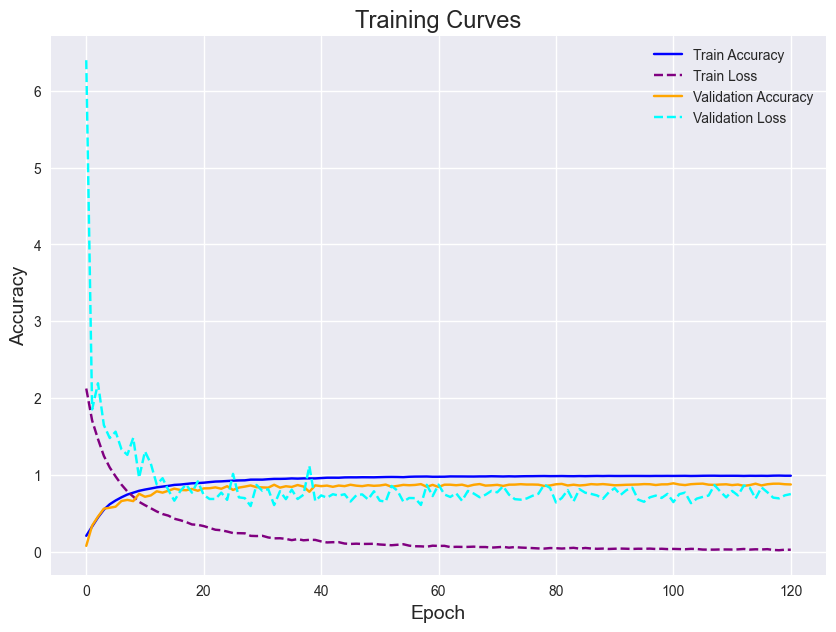

313/313 - 2s - loss: 0.6498 - accuracy: 0.8938 - 2s/epoch - 8ms/step
313/313 [==============================] - 2s 7ms/step
Test Accuracy: 0.89
Test Loss: 0.65
Test Precision: 0.89
Test Recall: 0.89
Test F1 Score: 0.89


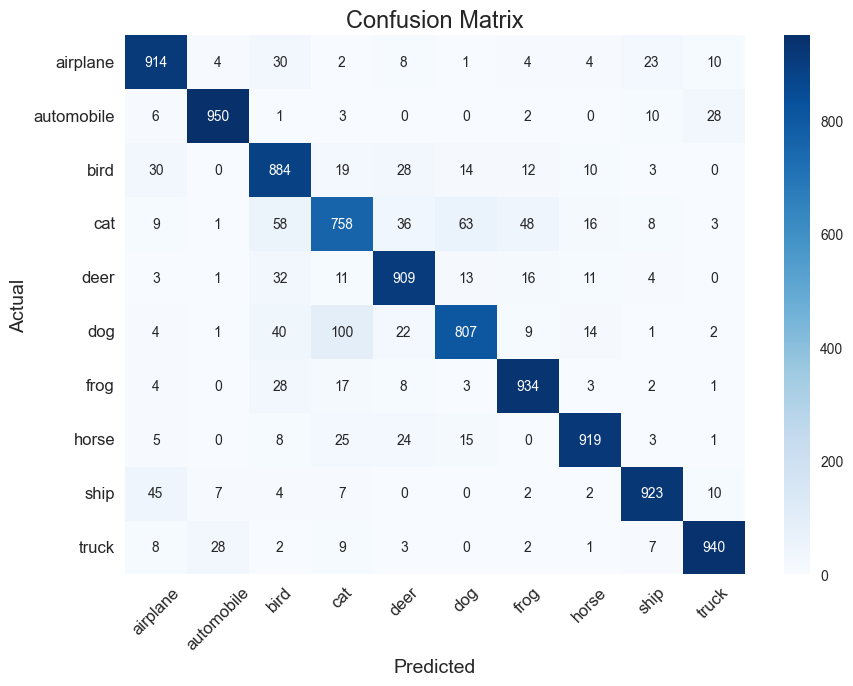

Finished FreezaNet ...


In [9]:
print(f'Starting '+'\033[35mFr\033[37mee\033[35mza' + '\033[37mNet' + '\033[0m' + ' ...')
model = models.Sequential()

# Block 1: Conv Block with Different Activations - 8 Layers
model.add(Conv_Block(num_filters=[64]*3, dropout_rate=0.25, input_shape=(32, 32, 3), activation=[mish, gelu, mish], kernel_size=[(3, 3)]*3, padding='same', strides=1, pool_size=[(2, 2)]*3))

# Block 2: Conv Block with Different Activations - 8 Layers
model.add(Conv_Block(num_filters=[128]*3, dropout_rate=0.25, input_shape=model.output.shape[1:], activation=[swish, swish, swish], kernel_size=[(3, 3)]*3, padding='same', strides=1, pool_size=[(2, 2)]*3))

# # Block 3: Inception Block with Different Activations - 8 Layers
# model.add(Inception_Block(num_filters=128, input_shape=model.output.shape[1:], activation=[mish, gelu, swish], kernel_size=[(3, 3)]*3, padding='same'))

# Block 4: Conv Block with Different Activations - 8 Layers
model.add(Conv_Block(num_filters=[256]*3, dropout_rate=0.25, input_shape=model.output.shape[1:], activation=[mish, gelu, mish], kernel_size=[(3, 3)]*3, padding='same', strides=1, pool_size=[(2, 2)]*3))

# Block 5: Identity Block with Different Activations - 6 Layers
# model.add(Identity_Block(model, num_filters=[256]*3, activation=[mish, gelu, swish], kernel_size=[(3, 3)]*3, padding='same'))

# Block 6: Conv Block with Different Activations - 8 Layers
model.add(Conv_Block(num_filters=[512]*3, dropout_rate=0.25, input_shape=model.output.shape[1:], activation=[swish, swish, swish], kernel_size=[(3, 3)]*3, padding='same', strides=1, pool_size=[(2, 2)]*3))

# Block 7: Identity Block with Different Activations - 6 Layers
# model.add(Identity_Block(model, num_filters=[512]*3, activation=[mish, gelu, swish], kernel_size=[(3, 3)]*3, padding='same'))

# Block 8: Applying Global Average Pooling to the model - 1 Layer
model.add(layers.GlobalAveragePooling2D())

# Block 8: Dense Block with Different Activations - 7 Layers
model.add(FC_Block(num_neurons=[512]*3, dropout_rate=0.5, input_shape=model.output.shape[1:], activation=[leaky_relu, swish, leaky_relu]))

# Block 9: Dense Block with Different Activations - 7 Layers
model.add(FC_Block(num_neurons=[256]*3, dropout_rate=0.5, input_shape=model.output.shape[1:], activation=[leaky_relu, swish, leaky_relu]))

# Block 10: Dense Block with Different Activations - 7 Layers
model.add(FC_Block(num_neurons=[128]*3, dropout_rate=0.5, input_shape=model.output.shape[1:], activation=[swish, swish, swish]))

# Block 11: Dense Block with Different Activations
model.add(FC_Block(num_neurons=[64]*3, dropout_rate=0.5, input_shape=model.output.shape[1:], activation=[swish, swish, swish]))

# Adding the output layer - 1 Layer
model.add(layers.Dense(10, activation='softmax'))

# Fitting the model
fit(
    model,
    verbose=1,
    epochs=200,
    batch_size=256,
    optimizer=Adam(clipnorm=3.0, learning_rate=0.007),
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)],
    colors=('blue', 'purple', 'orange', 'cyan'),
    do_display=True,
    do_save=True,
    save_name='freezanet',
)
print(f'Finished '+'\033[35mFr\033[37mee\033[35mza' + '\033[37mNet' + '\033[0m' + ' ...')